# stmfootball notebook

This notebook is designed as a chronological log of the approaches used to select a team.

In [4]:
# Import all the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns


In [ ]:
# YUCK!
import sys
import os
sys.path.append(os.getcwd() + "/src")
import src as football
from src.core import Season
from src.player import Player
from src.experiments import PredictorExperiment

## Approach

The approach we'll take in this notebook is as follows:

* Using the data before (and including) the 2021-22 season, try and train an model for optimising the number of points our fantasy team gets.
* Test this model on the 2022-23 season without hyperparamter tuning
* Deploy model on 2023-24 season

## Step 1: Explore the data

We are first going to start by exploring the 2021-2022 season of data to see what we have access to:

In [3]:
stats_2021_2022  = Path("./data/data/2021-22/players_raw.csv")
df = pd.read_csv(stats_2021_2022)
df.head()

,assists,bonus,bps,chance_of_playing_next_round,chance_of_playing_this_round,clean_sheets,code,corners_and_indirect_freekicks_order,corners_and_indirect_freekicks_text,cost_change_event,...,threat_rank_type,total_points,transfers_in,transfers_in_event,transfers_out,transfers_out_event,value_form,value_season,web_name,yellow_cards
0,0,0,69,100,100,1,80201,None,NaN,0,...,60,10,80974,0,205566,0,0.0,2.2,Leno,0
1,0,0,0,0,0,0,115918,None,NaN,0,...,19,0,19017,0,81363,0,0.0,0.0,Rúnarsson,0
2,0,0,0,0,0,0,47431,None,NaN,0,...,307,0,914,0,20541,0,0.0,0.0,Willian,0
3,1,7,131,0,0,6,54694,None,NaN,0,...,25,44,742898,0,900060,0,0.0,4.6,Aubameyang,3
4,1,3,292,100,100,3,58822,2,NaN,0,...,105,48,66997,0,55154,0,0.8,11.4,Cédric,3


It looks like a fairly even distribution of points across all the positions:

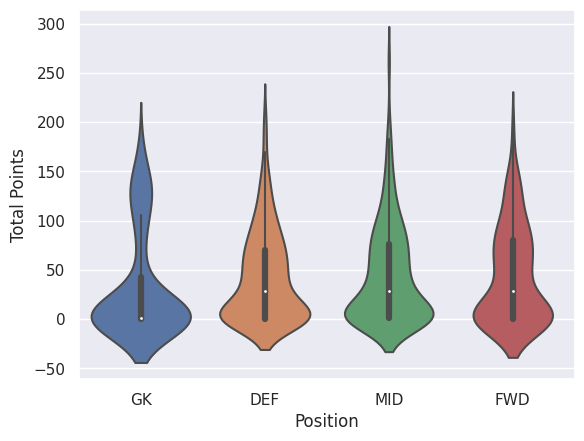

In [4]:
ax = sns.violinplot(
    data=df,
    x="element_type",
    y="total_points",
)
ax.set_xticklabels(["GK", "DEF", "MID", "FWD"])
ax.set_xlabel("Position")
ax.set_ylabel("Total Points")
plt.show()

By plotting the cost of a player against the number of points they get, see most people lie in a main cluster, with some outliers.

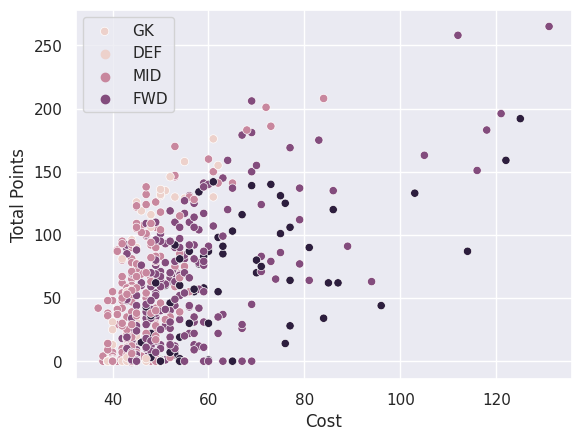

In [5]:
ax = sns.scatterplot(
    data=df,
    x="now_cost",
    y="total_points",
    hue="element_type",
)
ax.set_xlabel("Cost")
ax.set_ylabel("Total Points")
ax.legend(labels=["GK", "DEF", "MID", "FWD"])

Now let's make a new column on cost per point:

In [6]:
df["ppm"] = df["total_points"] / df["now_cost"]
df.sort_values(by="ppm", ascending=False).head(5)[["id", "first_name", "second_name", "ppm"]]

,id,first_name,second_name,ppm
373,224,Joel,Matip,3.207547
681,420,Jarrod,Bowen,2.985507
702,429,Conor,Coady,2.936170
380,231,Alisson,Ramses Becker,2.885246
579,353,Hugo,Lloris,2.872727


This is a slightly misleading direction and isn't what we're going to be the first strategy off, since players with a very small cost and average points gained might not be the best fit for the team, as we want to use as much of the budget as possible.

Let's however, take a look at the top 5's performance over time:

In [7]:
joel_matip = Player.from_pandas_row(df[df["second_name"] == "Matip"].iloc[0])

seasons = [Season.S2016_17, Season.S2017_18, Season.S2018_19, Season.S2019_20, Season.S2020_21]
history = joel_matip.get_historic_points_by_season(seasons)
print(history)

{2016/17: 97, 2017/18: 81, 2018/19: 83, 2019/20: 39, 2020/21: 42}


Now let's predict the number of points he'll get via a linear regression model (note the last point in this plot is on the line because it's predicted). The actual points he got is in red.

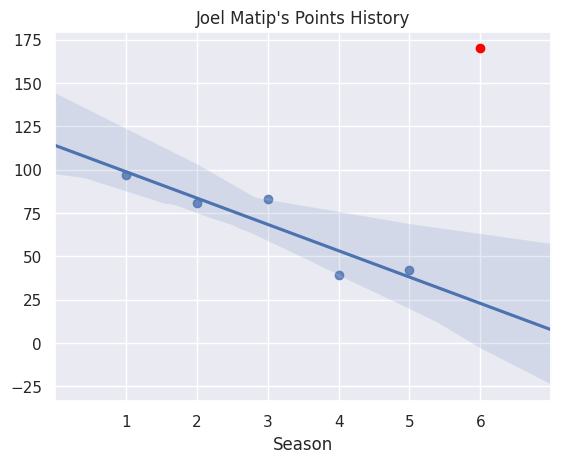

In [8]:
# Plot seasons that a model will see
fig, ax = plt.subplots()
ax.set_xlim((0, max(season.value for season in seasons) + 2))
ax = sns.regplot(x=[season.value for season in seasons], y=list(history.values()), ax=ax, truncate=False)
ax.set_title("Joel Matip's Points History")
ax.set_xlabel("Season")
ax.set_xticks([season.value for season in seasons] + [max(season.value for season in seasons) + 1])

# Plot actual value of 2021/22
next_season = Season(max(season.value for season in seasons) + 1)
ax.scatter([next_season.value], [sum(joel_matip.get_historic_points_for_season(next_season))], color="red")


Looks like he had a good year!

Let's apply this to every row in the dataframe, and sort by the players who outperformed their expected values

In [9]:
seasons = [Season.S2016_17, Season.S2017_18, Season.S2018_19, Season.S2019_20, Season.S2020_21]
df = football.analysis.add_predicted_points_to_df(df, seasons, predictor=football.predictors.LinearPredictor)
df["Point Delta"] = df["total_points"] - df["predicted_points"]
df.sort_values(by="Point Delta", ascending=False).head(20)[["id", "first_name", "second_name", "Point Delta"]]

,id,first_name,second_name,Point Delta
221,529,Romelu,Lukaku,168.6
466,579,Cristiano Ronaldo,dos Santos Aveiro,159.0
373,224,Joel,Matip,147.2
723,475,José,Malheiro de Sá,146.0
88,78,Ivan,Toney,139.0
645,450,Emmanuel,Dennis,134.0
197,121,Thiago,Emiliano da Silva,130.0
154,584,Marc,Cucurella,126.0
249,477,Marc,Guéhi,123.0
86,76,Pontus,Jansson,122.0


Let's plot this to have a look - we would expect the means to be around 0 as a similar number of players should over-perform as they do under-perform

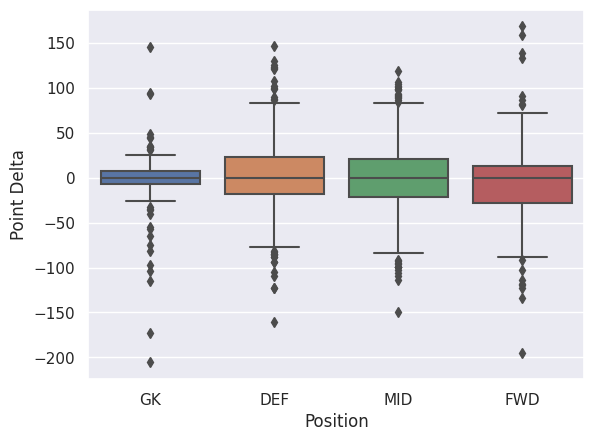

In [10]:
ax = sns.boxplot(
    data=df,
    x="element_type",
    y="Point Delta",
)

ax.set_xticklabels(["GK", "DEF", "MID", "FWD"])
ax.set_ylabel("Point Delta")
ax.set_xlabel("Position")
plt.show()

We've got some idea on what our data looks like now - we have a *very important* score (`total_points`) that we need to maximise for each player in our squad. How we do that is subject to some constraints (budget, team format, rules etc).

## Selecting an inital squad


We have two things to consider from now on - each player is taken in isolation so we don't have to worry about combinations of players.

* How do we value the players? We want to predict the amount of points they'll give us, and act accordingly
* How do we select the players based on their value? We could do this perfectly using an extension of a [Multiple Choice Knapsack Problem](https://link.springer.com/chapter/10.1007/978-3-540-24777-7_11), but this is algorithmically infeasible. So we need to approximate!

We use the following structures:

* The `Player` class implements a `predict_points_for_next_season` function that outputs some number representing an estimated value for the player in the next season. TODO: Port this out into a class
* The `SquadOptimiser` class (and it's children) define methods of taking the above values in the dataframe and selecting initial players based on an algorithm.

We start with two defaults:
* Linear Regression from previous data for the `predict_points_for_next_season` function
* A so-called `Efficient` algorithm that attempts to build a team from the "best value for money" players.

In [12]:
historical_data = []

seasons = [
    Season.S2016_17,
    Season.S2017_18,
    Season.S2018_19,
    Season.S2019_20,
    Season.S2020_21,
    Season.S2021_22,
    Season.S2022_23,
]

for _, row in df.iterrows():
    player = Player.from_pandas_row(row)
    historic_player = player.get_historic_points_by_season(seasons)
    historical_data.append(list(historic_player.values()))

historical_data = np.array(historical_data)
current_data = historical_data[:, -1]
historical_data = historical_data[:, :-1]

PredictorExperiment().run(
    historic_data=historical_data,
    current_data=current_data,
    predictors=[
        football.predictors.LSTMPredictor,
        football.predictors.ARIMAPredictor,
        football.predictors.LinearPredictor,
    ]
)

2023-08-12 15:30:06.440088: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-12 15:30:06.690174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-12 15:30:06.692045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMEN

Running predictor: LSTM


2023-08-12 15:30:06.900811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-12 15:30:06.902394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-12 15:30:06.903477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

24/24 [==============================] - 1s 3ms/step


2023-08-12 15:30:21.252932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-12 15:30:21.255014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-12 15:30:21.256696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Running predictor: ARIMA


KeyboardInterrupt: 

# Baseline Squad Generation

Let's come up with an emergency squad for this coming season then.

In [1]:
from src.strategy import Strategy

strategy = Strategy()
strategy.choose_squad()

2023-08-12 15:33:59.702865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 15:33:59.744490: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-12 15:33:59.745107: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-12 15:34:00.556779: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-12 15:34:11.484706: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gp

19/19 [==============================] - 0s 3ms/step


2023-08-12 15:34:25.640224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-08-12 15:34:25.641983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-08-12 15:34:25.643111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 25 (0) rows, 490 (-115) columns and 1470 (-345) elements
Clp1000I sum of infeasibilities 2.69053e-10 - average 1.07621e-11, 457 fixed columns
Coin0506I Presolve 10 (-15) rows, 33 (-457) columns and 83 (-1387) elements
Clp0029I End of values pass after 33 iterations
Clp0014I Perturbing problem by 0.001% of 1.2865787 - largest nonzero change 2.6094575e-05 ( 0.0013047287%) - largest zero change 1.7567739e-05
Clp0000I Optimal - objective value 2168.992
Clp0000I Optimal - objective value 2168.992
Coin0511I After Postsolve, objective 2168.992, infeasibilities - dual 0 (0), primal 0 (0)
Clp0014I Perturbing problem by 0.001% of 1.3114344 - largest nonzero change 2.6094575e-05 ( 0.0013047287%) - largest zero change 1.483952e-05
Clp0000I Optimal - objective value 2168.992
Clp0000I Optimal - objective value 2168.992
Clp000

In [15]:
strategy.squad

[César Azpilicueta,
 Raheem Sterling,
 Trent Alexander-Arnold,
 Andrew Robertson,
 Mohamed Salah,
 Kevin De Bruyne,
 Ederson Santana de Moraes,
 Aymeric Laporte,
 Mason Mount,
 Chris Wood,
 Eric Dier,
 Hugo Lloris,
 Michail Antonio,
 Jarrod Bowen,
 Danny Ings]

In [2]:
strategy.team

[Raheem Sterling,
 Trent Alexander-Arnold,
 Andrew Robertson,
 Mohamed Salah,
 Ederson Santana de Moraes,
 Aymeric Laporte,
 Mason Mount,
 Hugo Lloris,
 James Maddison,
 Jarrod Bowen,
 Danny Ings]

In [3]:
strategy.print_squad_stats(jupyter=True)


                                                      Squad                                                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Name                      ┃ Position ┃ Predicted Points ┃ Cost ┃ Is in Team? ┃ Is Captain? ┃ Is Vice Captain? ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Ederson Santana de Moraes │ GK       │ 135.26           │ 55   │ ✔️           │             │                  │
│ Hugo Lloris               │ GK       │ 126.90           │ 50   │ ✔️           │             │                  │
│ Trent Alexander-Arnold    │ DEF      │ 191.00           │ 80   │ ✔️           │             │ ✔️                │
│ Andrew Robertson          │ DEF      │ 166.64           │ 65   │ ✔️           │             │                  │
│ Aymeric Laporte           │ DEF      │ 118.42           │ 50   │ ✔️           │             │                  │
│ Reece James               │ DEF      │ 108.36           │ 55   │             │             │                  │
│ Eric Dier                 │ DEF      │ 97.61            │ 45   │             │             │                  │
│ Mohamed Salah             │ MID      │ 269.12           │ 125  │ ✔️           │ ✔️           │                  │
│ Raheem Sterling           │ MID      │ 174.29           │ 70   │ ✔️           │             │                  │
│ Jarrod Bowen              │ MID      │ 151.61           │ 70   │ ✔️           │             │                  │
│ James Maddison            │ MID      │ 145.90           │ 75   │ ✔️           │             │                  │
│ Mason Mount               │ MID      │ 140.98           │ 70   │ ✔️           │             │                  │
│ Danny Ings                │ FWD      │ 118.64           │ 60   │ ✔️           │             │                  │
│ Michail Antonio           │ FWD      │ 115.57           │ 60   │             │             │                  │
│ Raúl Jiménez              │ FWD      │ 108.67           │ 55   │             │             │                  │
└───────────────────────────┴──────────┴──────────────────┴──────┴─────────────┴─────────────┴──────────────────┘

             Summary Statistics              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Metric                        ┃ Value     ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ Total Cost                    │ 985       │
│ Total Predicted Points        │ 2168.992  │
│ Total Predicted Points (Team) │ 1738.7793 │
└───────────────────────────────┴───────────┘

True